In [4]:
import xarray as xr
import numpy as np
import cv2
import torch
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
from matplotlib import pyplot as plt


In [5]:
%load_ext autoreload
%matplotlib inline

import sys
sys.path.append('/Users/larrywu/Documents/python-arpes/')
sys.path.append('/Users/larrywu/Documents')
%autoreload 2
from arpes.all import *
from pathlib import Path
import numpy as np
import xarray as xr
from arpes.typing import DataType
from arpes.corrections.fermi_edge_corrections import fix_fermi_edge
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.special import expit 
from tabulate import tabulate
from scipy.signal import convolve
from functions import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:


# === Step 1: Load Your ARPES Data ===
# Replace 'data.nc' and 'intensity' with your actual file and variable names.
ds = xr.open_dataset('data1.nc')
ds=ds['spectrum'][0]
data = ds.values  # assuming data shape is (H, W), grayscale

# === Step 2: Preprocess the Data ===
# Normalize the grayscale data to [0, 1]
data_norm = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)

# Convert the 2D grayscale array to a 3-channel image by repeating the single channel along the last axis.
data_3ch = np.repeat(data_norm[..., np.newaxis], 3, axis=-1)

# Convert the normalized image to 8-bit unsigned integers (range 0–255)
img_uint8 = (data_3ch * 255).astype(np.uint8)


In [7]:


# === Step 3: Setup the Real‑ESRGAN Model ===
model = RRDBNet(
    num_in_ch=3,
    num_out_ch=3,
    num_feat=64,
    num_block=23,
    num_grow_ch=32,
    scale=4
)

upscaler = RealESRGANer(
    scale=4,
    model_path='weights/RealESRGAN_x4plus.pth',  # update this path as needed
    model=model,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=False
)

# === Step 4: Perform Super-Resolution ===
sr_image, _ = upscaler.enhance(img_uint8, outscale=4)

# === Step 5: (Optional) Convert the Output Back to Grayscale ===
# If you want to convert the super-resolved image back to grayscale,
# you can use OpenCV's conversion function.
sr_gray = cv2.cvtColor(sr_image, cv2.COLOR_BGR2GRAY)
sr_gray_norm = sr_gray.astype(np.float32) / 255.0

# === Step 6: Wrap the Output in an xarray DataArray ===
sr_da = xr.DataArray(
    sr_gray_norm,
    dims=('y', 'x'),
    coords={
        'y': np.arange(sr_gray_norm.shape[0]),
        'x': np.arange(sr_gray_norm.shape[1])
    }
)
print("Original DataArray shape:", data.shape)
print("Super-resolution complete! Resulting DataArray shape:", sr_da.shape)


Original DataArray shape: (476, 384)
Super-resolution complete! Resulting DataArray shape: (1904, 1536)


In [8]:
sr_eV=np.linspace(ds.eV[0],ds.eV[-1],sr_da.shape[0])
sr_phi=np.linspace(ds.phi[0],ds.phi[-1],sr_da.shape[1])
sr_data=xr.DataArray(sr_da.values,coords=[sr_eV,sr_phi],dims=['eV','phi'])

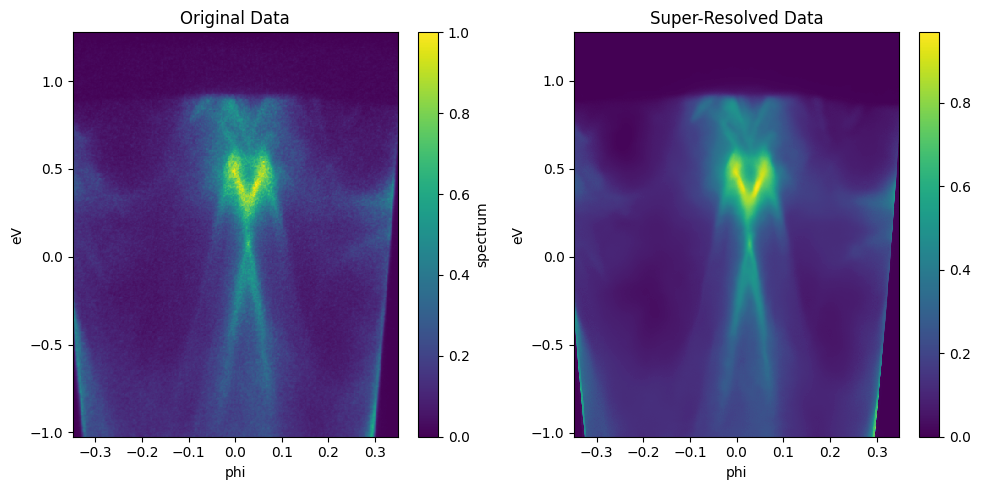

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
((ds - np.min(ds)) / (np.max(ds) - np.min(ds) + 1e-8)).S.plot(ax=ax[0])
ax[0].set_title('Original Data')
sr_data.plot(ax=ax[1])
ax[1].set_title('Super-Resolved Data')

plt.tight_layout()

Text(0.5, 1.0, 'Super-Resolved Data')

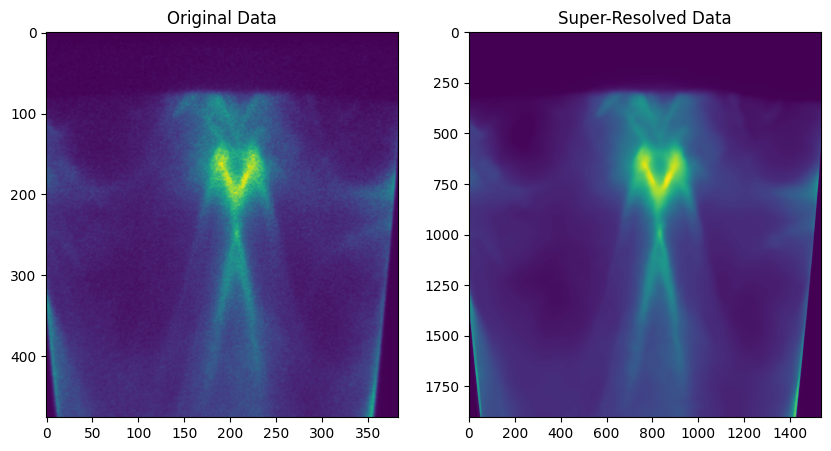

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.flipud(data),aspect='auto')
ax[0].set_title('Original Data')
ax[1].imshow(np.flipud(sr_da),aspect='auto')
ax[1].set_title('Super-Resolved Data')


Text(0.5, 1.0, 'Super-Resolved Data')

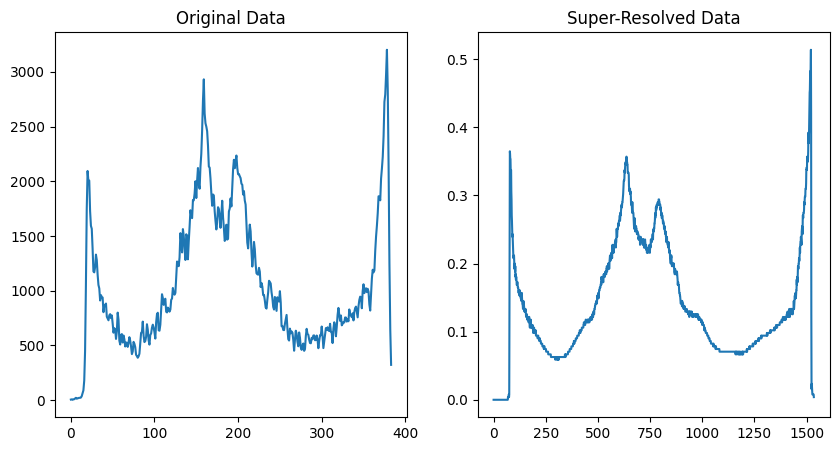

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cut_n=100
ax[0].plot(np.flipud(data[cut_n]))
ax[0].set_title('Original Data')
ax[1].plot(np.flipud(sr_da[cut_n*sr_da.shape[0]//data.shape[0]]))
ax[1].set_title('Super-Resolved Data')


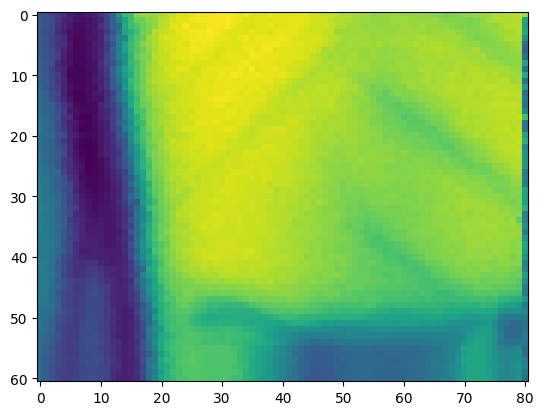

In [ ]:
root=Path("/Users/larrywu/Desktop/TaTe2/2023_1104_nARPES")
xymap=load_data(root/"20231104_00312.fits", location = "BL7")
xymap.coords['phi'] = (0.181/200)*(xymap.coords['phi']-xymap.phi.mean()).copy(deep=True)

xymap=xymap.sel(phi=slice(-0.0002,0.0002)).sel(eV=slice(-1,0)).mean('eV').mean("phi").spectrum
xymap_norm = np.array((xymap - np.min(xymap)) / (np.max(xymap) - np.min(xymap) + 1e-8).values)
xymap_3ch = np.repeat(xymap_norm[..., np.newaxis], 3, axis=-1)

# Convert the normalized image to 8-bit unsigned integers (range 0–255)
xymap_uint8 = (xymap_3ch * 255).astype(np.uint8)
plt.imshow(xymap_norm)

In [60]:
sr_xymap, _ = upscaler.enhance(xymap_uint8, outscale=10)

# === Step 5: (Optional) Convert the Output Back to Grayscale ===
# If you want to convert the super-resolved image back to grayscale,
# you can use OpenCV's conversion function.
sr_gray_xymap = cv2.cvtColor(sr_xymap, cv2.COLOR_BGR2GRAY)
sr_gray_xymap_norm = sr_gray_xymap.astype(np.float32) / 255.0

# === Step 6: Wrap the Output in an xarray DataArray ===
sr_xymap = xr.DataArray(
    sr_gray_xymap_norm,
    dims=('scan_y', 'scan_x'),
    coords={
        'scan_y': np.arange(sr_gray_xymap_norm.shape[0]),
        'scan_x': np.arange(sr_gray_xymap_norm.shape[1])
    }
)
print("Original DataArray shape:", xymap.shape)
print("Super-resolution complete! Resulting DataArray shape:", sr_xymap.shape)

Original DataArray shape: (61, 81)
Super-resolution complete! Resulting DataArray shape: (610, 810)


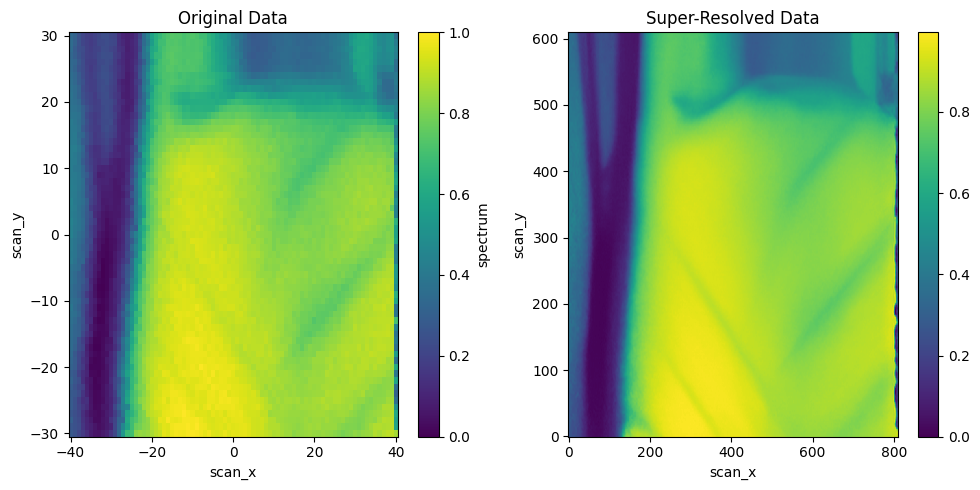

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
((xymap - np.min(xymap)) / (np.max(xymap) - np.min(xymap) + 1e-8)).S.plot(ax=ax[0])
ax[0].set_title('Original Data')
sr_xymap.plot(ax=ax[1])
ax[1].set_title('Super-Resolved Data')

plt.tight_layout()

In [66]:
import cv2
cv2.cvtColor(xymap_norm, cv2.COLOR_GRAY2RGB)

error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<1>, cv::impl::(anonymous namespace)::Set<3, 4>, cv::impl::(anonymous namespace)::Set<0, 2, 5>>::CvtHelper(InputArray, OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


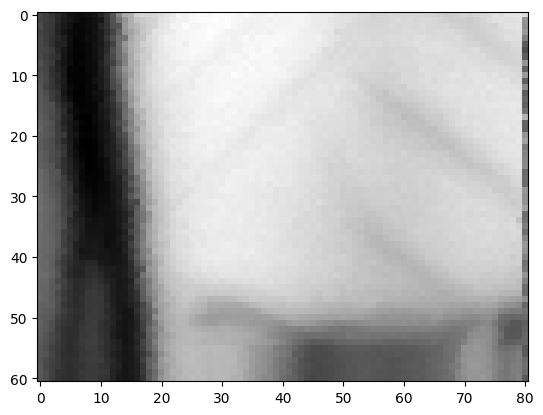

In [67]:
plt.imshow(xymap_3ch)